# MOVIE RECOMENDER SYSTEM ML

Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

## 1. CONFIGURACIÓN DEL AMBIENTE

In [1]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 2.1.4
------
Name: matplotlib
Version: 3.7.1


In [2]:
%%capture
!pip install requests
!pip install pillow
!pip install ipywidgets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import requests
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import re
import os
import sys
import random
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_links, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1581k      0 --:--:-- --:--:-- --:--:-- 1584k


## 2. OBTENCIÓN, TRATAMIENTO Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)

### 2.1 OBTENCIÓN DE LA DATA

In [4]:
df_movies = pd.read_csv('/content/data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings = pd.read_csv('/content/data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


In [6]:
df_links = pd.read_csv('/content/data/ml-latest-small/links.csv')
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.00
1,2,113497,8844.00
2,3,113228,15602.00
3,4,114885,31357.00
4,5,113041,11862.00


In [7]:
df_tags = pd.read_csv('/content/data/ml-latest-small/tags.csv')
df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
df_movies = df_movies.drop(df_movies[df_movies['title'] == "'Salem's Lot (2004)"].index)


In [9]:
df_movies['movieId'].nunique()

9741

In [10]:
df_ratings['movieId'].nunique()

9724

In [11]:
df_links['movieId'].nunique()

9742

In [12]:
df_tags['movieId'].nunique() #no se usa

1572

### 2.2 TRATAMIENTO DE DATOS

In [13]:
print('-------'*5)
print('INFORMACIÓN DE LOS DATAFRAMES')
print('-------'*5)
df_movies.info()
print('-------'*5)
df_ratings.info()
print('-------'*5)
df_links.info()
print('-------'*5)
# df_tags.info()

-----------------------------------
INFORMACIÓN DE LOS DATAFRAMES
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 9741 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9741 non-null   int64 
 1   title    9741 non-null   object
 2   genres   9741 non-null   object
dtypes: int64(1), object(2)
memory usage: 304.4+ KB
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data col

In [14]:
def preprocesamiento():
  global df_movies, df_ratings, df_links, df_final

  ## Eliminando valores nulos y duplicados
  df_movies = df_movies.dropna().drop_duplicates()
  df_ratings = df_ratings.dropna().drop_duplicates()
  df_links = df_links.dropna().drop_duplicates()

  ## Feature Engineering
  df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))
  df_movies['content'] = df_movies['genres'].str.replace('|', ' ')

  ## Cambiando el tipo de dato timestamp
  df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

  ## Validando los tipos de datos en df_links
  df_links['tmdbId'] = df_links['tmdbId'].astype(int)
  df_links['imdbId'] = df_links['imdbId'].astype(int)

  ## Creando el dataframe final
  df_final = pd.merge(df_movies, df_ratings, on='movieId', how='inner')
  df_final = pd.merge(df_final, df_links, on='movieId', how='inner')

  df_final['year'] = df_final['timestamp'].dt.year
  # df_final['year'] = df_final['year'].astype(int)
  df_final.drop(columns=['timestamp'], inplace=True)

  return df_final

In [15]:
df_final = preprocesamiento()
df_final.head()

,movieId,title,genres,genre_set,content,userId,rating,imdbId,tmdbId,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,1,4.00,114709,862,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,5,4.00,114709,862,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,7,4.50,114709,862,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,15,2.50,114709,862,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,17,4.50,114709,862,2011


In [16]:
df_final['movieId'].nunique()

9715

In [17]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100822 entries, 0 to 100821
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100822 non-null  int64  
 1   title      100822 non-null  object 
 2   genres     100822 non-null  object 
 3   genre_set  100822 non-null  object 
 4   content    100822 non-null  object 
 5   userId     100822 non-null  int64  
 6   rating     100822 non-null  float64
 7   imdbId     100822 non-null  int64  
 8   tmdbId     100822 non-null  int64  
 9   year       100822 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 7.3+ MB


### 2.3 ANÁLISIS EXPLORATORIO DE DATOS (EDA)

In [18]:
df_final.describe()

,movieId,userId,rating,imdbId,tmdbId,year
count,100822.00,100822.00,100822.00,100822.00,100822.00,100822.00
mean,19435.36,326.13,3.50,351570.39,20105.30,2007.72
std,35532.46,182.62,1.04,622095.25,53274.38,6.89
min,1.00,1.00,0.50,417.00,2.00,1996.00
25%,1199.00,177.00,3.00,99685.00,712.00,2002.00
50%,2991.00,325.00,3.50,118771.00,6957.00,2007.00
75%,8119.00,477.00,4.00,314979.00,11635.00,2015.00
max,193609.00,610.00,5.00,8391976.00,525662.00,2018.00


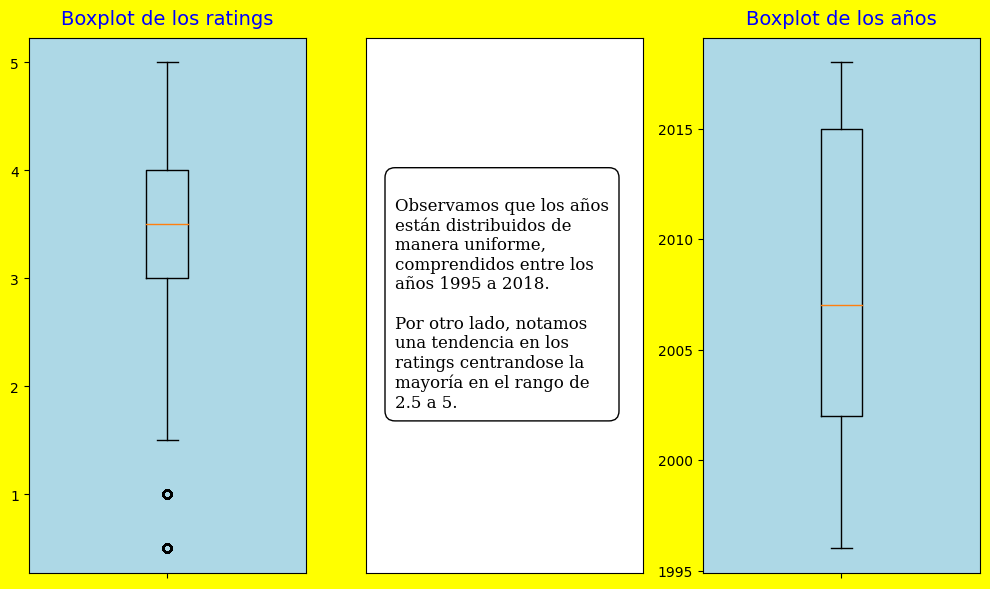

In [19]:
figure, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 6), dpi=100)
ax1.boxplot(df_final['rating'])
ax1.set_title('Boxplot de los ratings', fontdict={'fontsize': 14, 'color':'blue', 'fontweight': 'normal'}, pad=10)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_facecolor('lightblue')

# Quitar las marcas (ticks) de los ejes x e y
ax2.set_xticks([])
ax2.set_yticks([])

# Añadir texto de conclusión
conclusion_text = '''
Observamos que los años
están distribuidos de
manera uniforme,
comprendidos entre los
años 1995 a 2018.

Por otro lado, notamos
una tendencia en los
ratings centrandose la
mayoría en el rango de
2.5 a 5.'''

plt.figtext(0.4, 0.5, conclusion_text, fontdict={'fontsize': 12, 'fontfamily':'serif', 'fontstyle':'normal', 'fontweight': 'normal', 'color': 'black'}, va='center', ha='left',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.6'))

ax3.boxplot(df_final['year'])
ax3.set_title('Boxplot de los años', fontdict={'fontsize': 14, 'color':'blue', 'fontweight': 'normal'}, pad=10)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax3.set_facecolor('lightblue')

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('yellow')

plt.tight_layout()
plt.show()

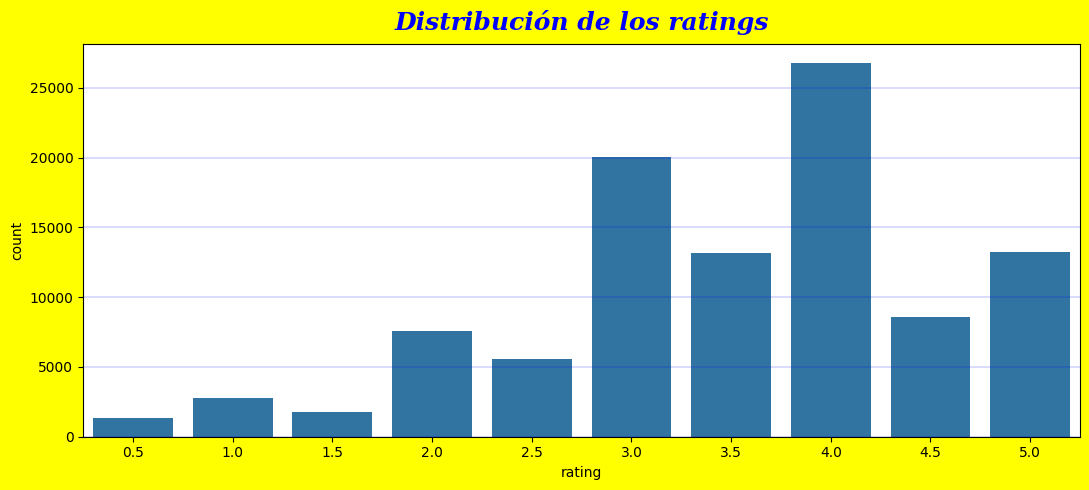

In [20]:
plt.figure(figsize=(11, 5))
sns.barplot(x = df_final['rating'].value_counts().index, y = df_final['rating'].value_counts())
plt.title('Distribución de los ratings', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': 'blue',
                                                          'fontstyle': 'italic', 'fontfamily': 'serif', 'fontstretch': 'condensed',
                                                          'fontvariant': 'small-caps'}, pad=10)

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('yellow')

plt.grid(axis='y', color='b', linestyle='-', linewidth =0.2)
plt.tight_layout()
plt.show()

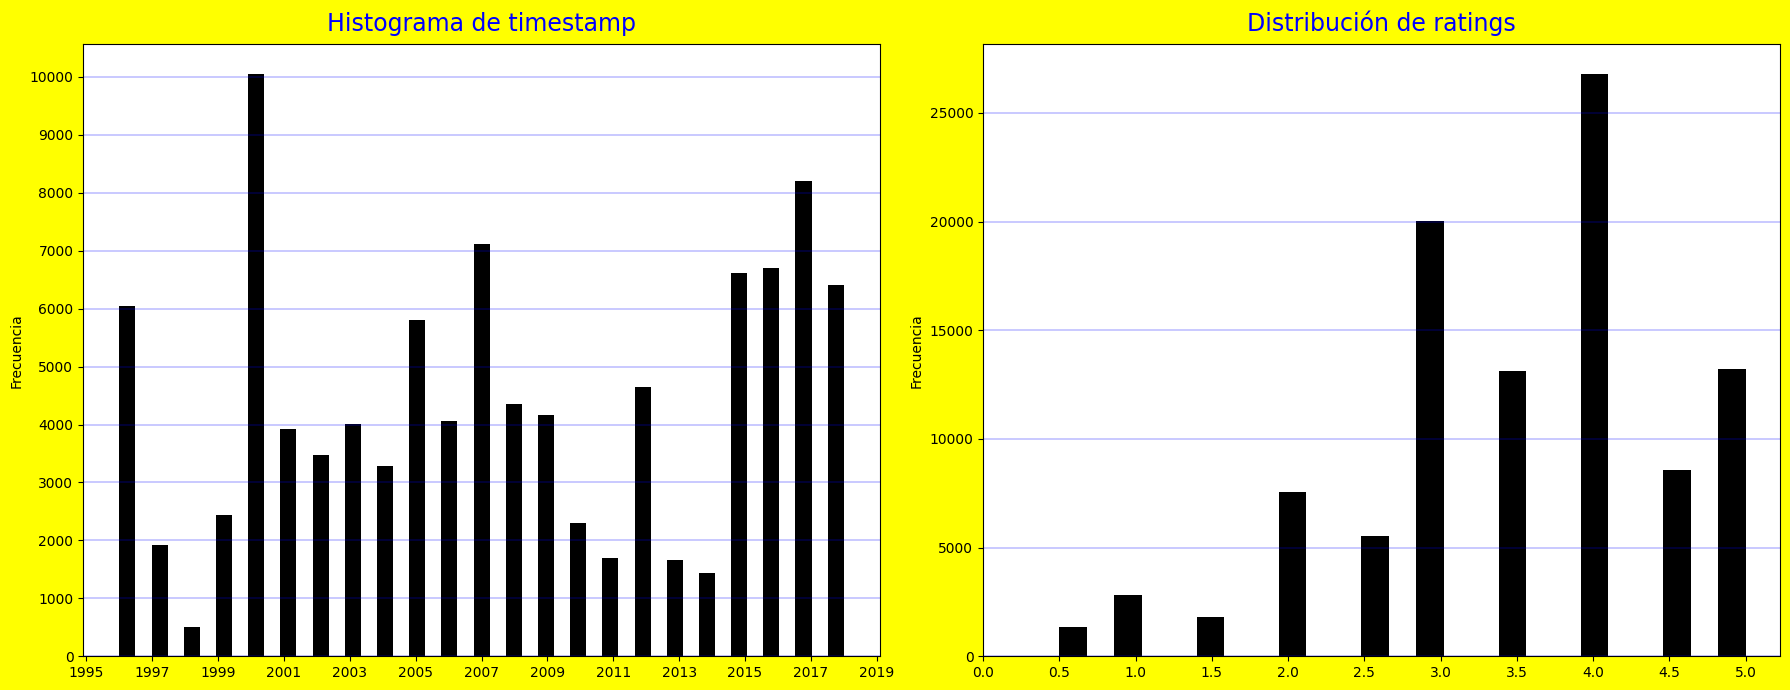

In [21]:
figure, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 7))

## Histograma de los años
ax1.hist(df_final['year'], bins=45, color='black')
ax1.set_title('Histograma de timestamp', fontdict={'fontsize': 17, 'color':'blue', 'fontweight': 'normal'}, pad=10)
ax1.set_xticks(range(1995, 2020, 2))
ax1.set_yticks(range(0, 10001, 1000))
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', color='b', linestyle='-', linewidth =0.3)

## Histograma de los Ratings
ax2.hist(df_final['rating'], bins=25, color='black')
ax2.set_title('Distribución de ratings', fontdict={'fontsize': 17, 'color':'blue', 'fontweight': 'normal'}, pad=10)
ax2.set_xticks(np.arange(0, 5.5, 0.5))
ax2.set_ylabel('Frecuencia')
ax2.grid(axis='y', color='b', linestyle='-', linewidth =0.3)

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('yellow')

plt.tight_layout()
plt.show()

In [22]:
df_final['title'].value_counts().head(10)

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


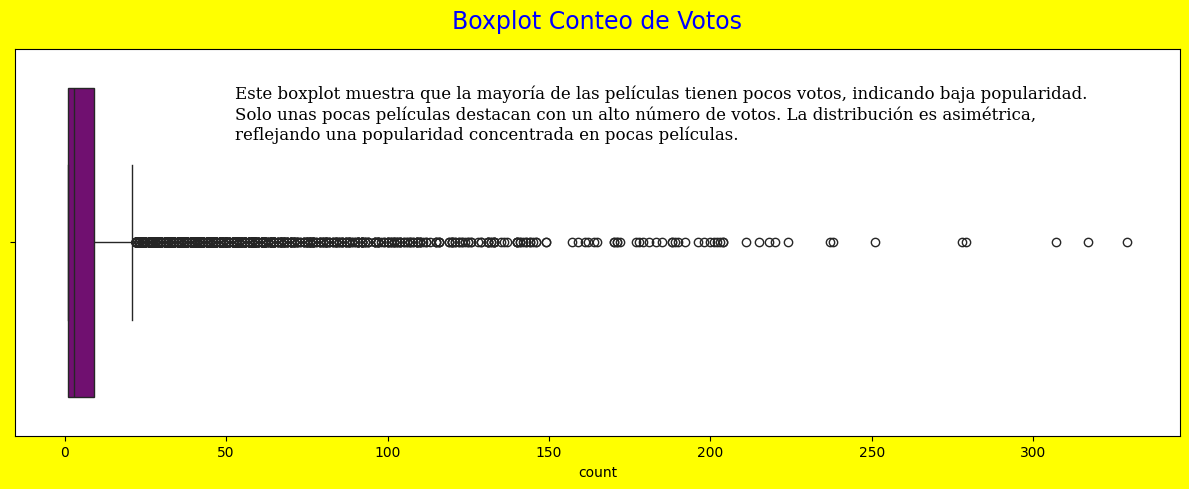

In [23]:
plt.figure(figsize=(12, 5))
sns.boxplot(df_final['title'].value_counts(), orient='h', color='purple')

# Añadir texto de conclusión
conclusion_text = '''
Este boxplot muestra que la mayoría de las películas tienen pocos votos, indicando baja popularidad.
Solo unas pocas películas destacan con un alto número de votos. La distribución es asimétrica,
reflejando una popularidad concentrada en pocas películas.'''

plt.figtext(0.2, 0.78, conclusion_text, fontdict={'fontsize': 12, 'fontfamily':'serif', 'fontstyle':'normal', 'fontweight': 'normal', 'color': 'black'}, va='center', ha='left')

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('yellow')

plt.title('Boxplot Conteo de Votos', pad=15, fontdict={'fontsize': 17, 'color':'blue', 'fontweight': 'normal'})
plt.tight_layout()
plt.show()

1. ** **POPULARIDAD CONSIDERANDO RATING Y CONTEO DE VOTOS** **

Para calcular la popularidad en porcentaje utilizando tanto el rating como el conteo de votos, puedes usar una fórmula que combine ambos factores. Una manera común de hacerlo es ponderar el rating por el conteo de votos, normalizando ambos valores para que estén en un rango de 0 a 1 y luego multiplicarlos para obtener un porcentaje.

Aquí tienes una fórmula básica para calcular la popularidad en porcentaje:



popularidad = (rating / rating_maximo)* (conteo_votos/conteo_votos_maximo)*100

In [24]:
df_scatter = df_final.groupby('title').agg({'rating': 'mean', 'title':'count'}).rename(columns={'title': 'vote_count'}).sort_values(by='vote_count', ascending=False).reset_index()
max_rating = df_scatter['rating'].max()
max_vote_count = df_scatter['vote_count'].max()
df_scatter['popularity %'] = (df_scatter['vote_count']/max_vote_count)*(df_scatter['rating']/max_rating)*100
df_scatter.head(20)

,title,rating,vote_count,popularity %
0,Forrest Gump (1994),4.16,329,83.28
1,"Shawshank Redemption, The (1994)",4.43,317,85.35
2,Pulp Fiction (1994),4.20,307,78.33
3,"Silence of the Lambs, The (1991)",4.16,279,70.58
4,"Matrix, The (1999)",4.19,278,70.85
5,Star Wars: Episode IV - A New Hope (1977),4.23,251,64.56
6,Jurassic Park (1993),3.75,238,54.26
7,Braveheart (1995),4.03,237,58.09
8,Terminator 2: Judgment Day (1991),3.97,224,54.07
9,Schindler's List (1993),4.22,220,56.50


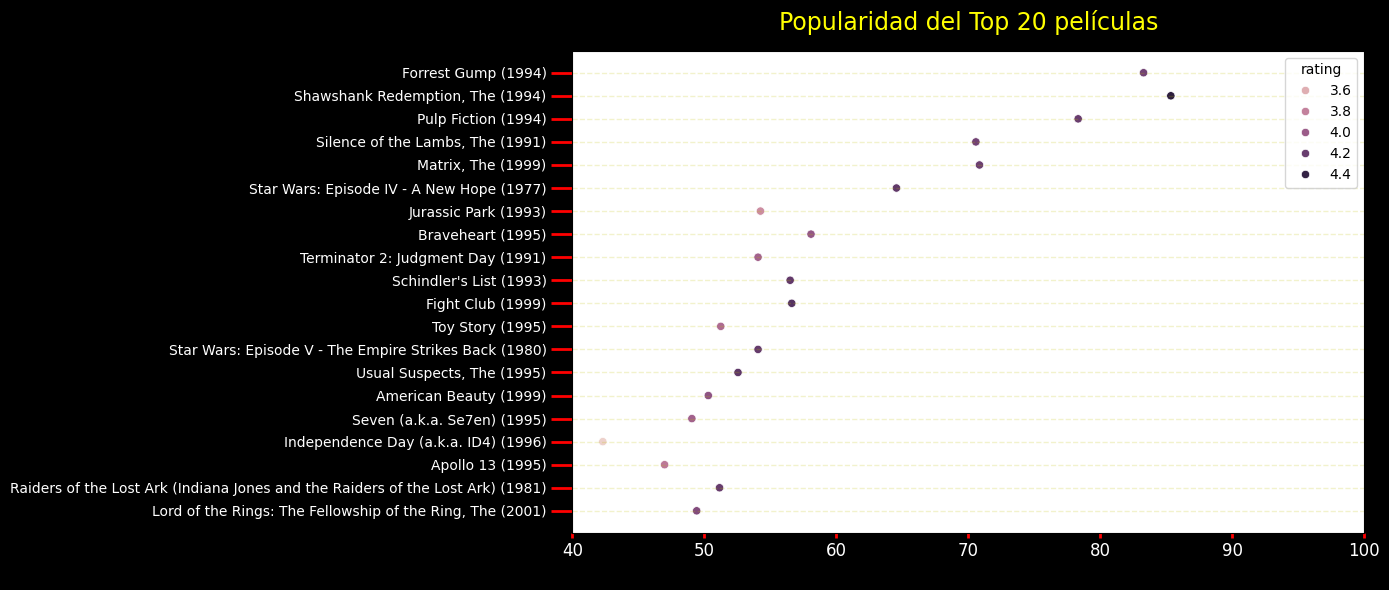

In [25]:
plt.figure(figsize=(14, 6))
sns.scatterplot(df_scatter.head(20), y='title', x='popularity %', hue='rating')
plt.title('Popularidad del Top 20 películas', pad=15, fontdict={'fontsize': 17, 'color':'yellow', 'fontweight': 'normal'})
plt.xticks(np.arange(40, 101, 10))
plt.ylabel('')

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')

# Cambiar el color de las etiquetas en el eje x - y
plt.tick_params(axis='y', labelcolor='white', width=2, length = 15, colors='r', grid_color='r',grid_alpha=0.2)
plt.tick_params(axis='x', labelcolor='white', width=2, labelsize='large', colors='r', grid_color='r',grid_alpha=0.2)

plt.tight_layout()
plt.grid(axis='y', color='y', linestyle='--', linewidth =1)
plt.show()

2. ** **DISTRIBUCIÓN DE GÉNEROS DE PELÍCULAS** **

In [26]:
df_stack = df_final['genres'].str.split('|', expand=True).stack().value_counts()
df_stack = df_stack.sort_values(ascending=False).reset_index()
df_stack

,index,count
0,Drama,41925
1,Comedy,39050
2,Action,30635
3,Thriller,26447
4,Adventure,24157
5,Romance,18123
6,Sci-Fi,17236
7,Crime,16679
8,Fantasy,11834
9,Children,9208


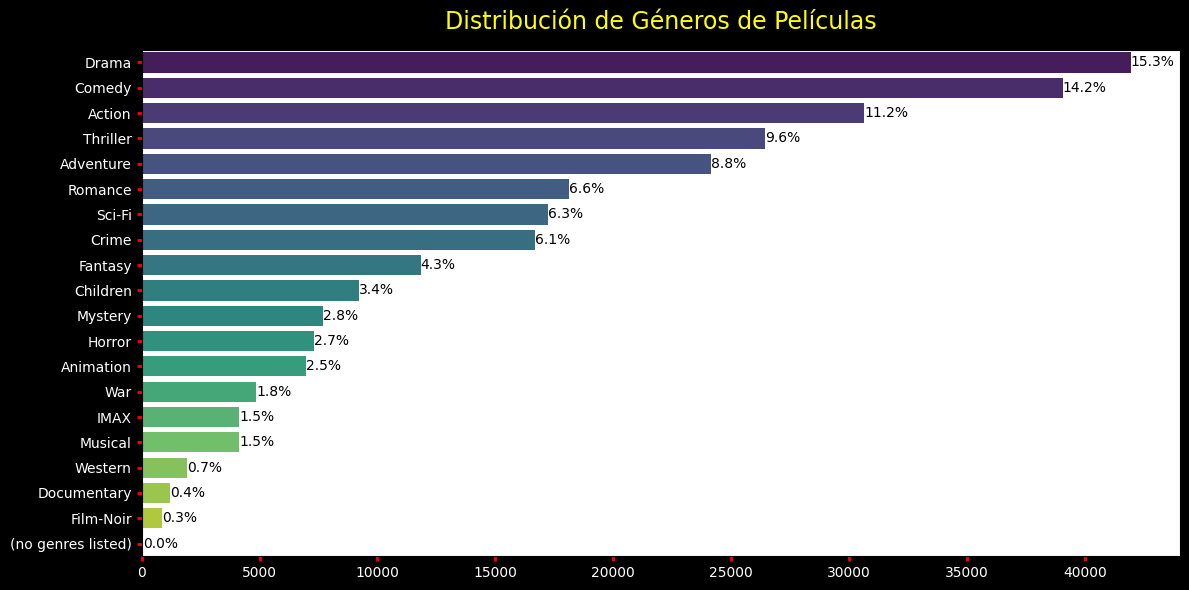

In [27]:
plt.figure(figsize=(12, 6))

# Genera una paleta de colores brillantes
colors = sns.color_palette("viridis", len(df_stack))

# Calcular el total para obtener los porcentajes
total = df_stack['count'].sum()

# Crear el gráfico de barras
bars = sns.barplot(data=df_stack, y='index', x='count', palette=colors)
plt.title('Distribución de Géneros de Películas', pad=15, fontdict={'fontsize': 17, 'color':'yellow', 'fontweight': 'normal'})
plt.ylabel('')
plt.xlabel('')

# Agregar los porcentajes sobre las barras
for bar in bars.patches:
    width = bar.get_width()
    height = bar.get_height()
    y = bar.get_y()
    media = bar.get_y() + bar.get_height() / 2
    # print((width, height, y, media))
    percentage = f'{100 * width / total:.1f}%'
    plt.text(width, media, percentage,  # Ajustando posición horizontal y vertical
              ha='left', va='center', color='black')  #, fontweight='bold'

# Establecer el color de fondo del gráfico
plt.gcf().set_facecolor('black')

# Cambiar el color de las etiquetas en el eje x - y
plt.tick_params(axis='x', labelcolor='white', width=2, colors='r', grid_color='r',grid_alpha=0.2)
plt.tick_params(axis='y', labelcolor='white', width=2, colors='r', grid_color='r',grid_alpha=0.2)

plt.tight_layout()
plt.show()

## 3. ESTRATEGIA DE RECOMENDACIÓN

In [28]:
df_final.head()

,movieId,title,genres,genre_set,content,userId,rating,imdbId,tmdbId,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,1,4.00,114709,862,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,5,4.00,114709,862,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,7,4.50,114709,862,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,15,2.50,114709,862,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,17,4.50,114709,862,2011


### 3.1 RECOMENDACIÓN NO PERSONALIZADA

### <ins>**RECOMENDACIÓN BASADA EN RATING Y CONTEO DE VOTOS - SIMPLE**</ins>

In [29]:
def calcular_top_items():
    global df_final
    df_final_2 = df_final.copy()
    df_final_2 = df_final_2.drop(columns=['genres', 'genre_set', 'content'])
    num_votos = df_final_2['title'].value_counts()
    popular_movies = num_votos[num_votos > 210].index
    df_popular = df_final_2[df_final_2['title'].isin(popular_movies)]

    mean_rating = df_popular.groupby('title')['rating'].mean()

    df_stats = pd.DataFrame({
        'movieId': df_final_2.groupby('title')['movieId'].first(),
        'tmdbId': df_final_2.groupby('title')['tmdbId'].first(),
        'imdbId': df_final_2.groupby('title')['imdbId'].first(),
        'year': df_final_2.groupby('title')['year'].first(),
        'mean_rating': mean_rating,
        'num_votos': df_popular['title'].value_counts()
    })

    top_10_items = df_stats.sort_values(by='mean_rating', ascending=False).head(10).reset_index()
    print('Las películas más populares son:')
    return top_10_items

calcular_top_items()

Las películas más populares son:


,title,movieId,tmdbId,imdbId,year,mean_rating,num_votos
0,"Shawshank Redemption, The (1994)",318,278,111161,2015,4.43,317.00
1,Fight Club (1999),2959,550,137523,2000,4.27,218.00
2,Star Wars: Episode IV - A New Hope (1977),260,11,76759,2000,4.23,251.00
3,Schindler's List (1993),527,424,108052,2000,4.22,220.00
4,Star Wars: Episode V - The Empire Strikes Back...,1196,1891,80684,2000,4.22,211.00
5,Pulp Fiction (1994),296,680,110912,2000,4.20,307.00
6,"Matrix, The (1999)",2571,603,133093,2000,4.19,278.00
7,Forrest Gump (1994),356,13,109830,2000,4.16,329.00
8,"Silence of the Lambs, The (1991)",593,274,102926,2000,4.16,279.00
9,Braveheart (1995),110,197,112573,2000,4.03,237.00


### <ins>**RECOMENDACIÓN BASADA EN PROMEDIO BAYESIANO**</ins>

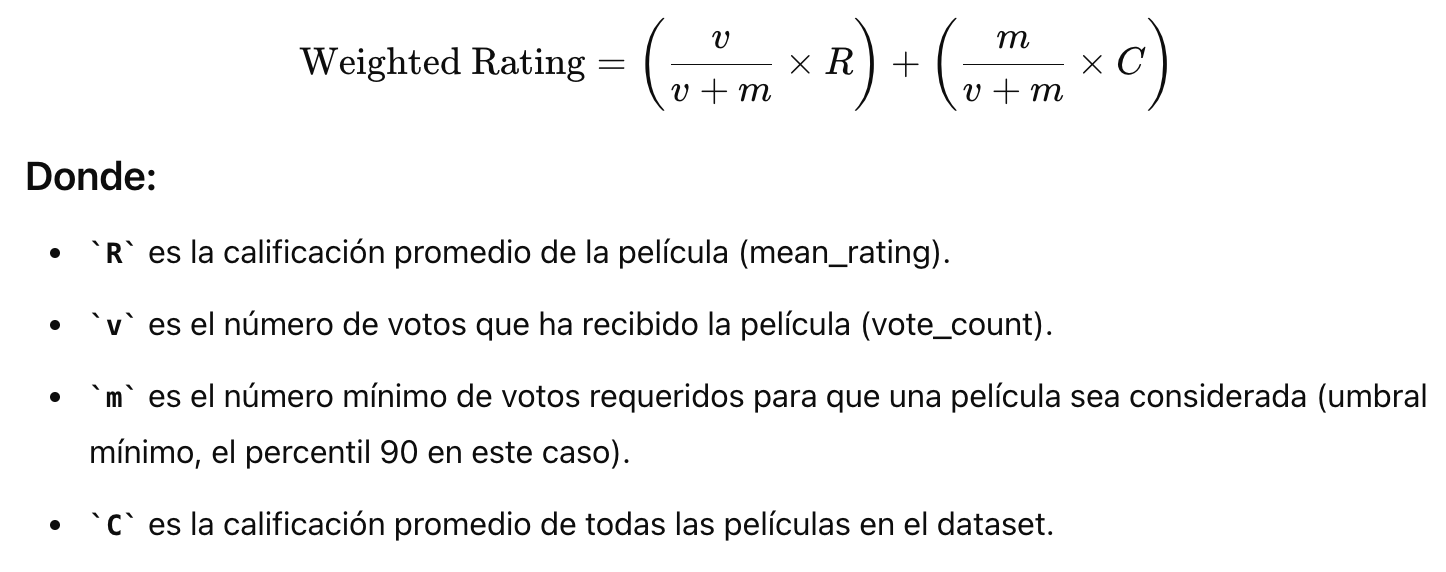

In [30]:
def calcular_top_items_bayesian():
    global df_final
    df_final_2 = df_final.copy()
    df_final_2 = df_final_2.drop(columns=['genres', 'genre_set', 'content'])
    df_final_2 = df_final_2.drop_duplicates()

    mean_rating = df_final_2.groupby('title')['rating'].mean()

    df_stats = pd.DataFrame({
        'movieId': df_final_2.groupby('title')['movieId'].first(),
        'tmdbId': df_final_2.groupby('title')['tmdbId'].first(),
        'imdbId': df_final_2.groupby('title')['imdbId'].first(),
        'year': df_final_2.groupby('title')['year'].first(),
        'mean_rating': mean_rating,
        'num_votos': df_final_2['title'].value_counts()
    })

    m = df_stats['num_votos'].quantile(0.9)
    df_stats = df_stats[df_stats['num_votos'] >= m]
    c = df_stats['mean_rating'].mean()


    df_stats['weighted_rating'] = (df_stats['mean_rating'] * (df_stats['num_votos'] / (df_stats['num_votos'] + m)) +
                                   c * (m / (m + df_stats['num_votos'])))

    top_10_items = df_stats.sort_values(by='weighted_rating', ascending=False).head(10).reset_index()
    # print('Las películas recomendadas son:')
    return top_10_items

calcular_top_items_bayesian()

,title,movieId,tmdbId,imdbId,year,mean_rating,num_votos,weighted_rating
0,"Shawshank Redemption, The (1994)",318,278,111161,2015,4.43,317,4.36
1,"Godfather, The (1972)",858,238,68646,2017,4.29,192,4.20
2,Fight Club (1999),2959,550,137523,2000,4.27,218,4.19
3,Star Wars: Episode IV - A New Hope (1977),260,11,76759,2000,4.23,251,4.17
4,"Usual Suspects, The (1995)",50,629,114814,2000,4.24,204,4.16
5,Schindler's List (1993),527,424,108052,2000,4.22,220,4.15
6,Pulp Fiction (1994),296,680,110912,2000,4.20,307,4.15
7,Star Wars: Episode V - The Empire Strikes Back...,1196,1891,80684,2000,4.22,211,4.14
8,"Godfather: Part II, The (1974)",1221,240,71562,2011,4.26,129,4.14
9,"Matrix, The (1999)",2571,603,133093,2000,4.19,278,4.14


* UTILIZANDO WIDGETS

In [31]:
import ipywidgets as widgets
from IPython.display import display, HTML
import requests

# Supongamos que ya tienes un DataFrame con las películas
df = df_final.groupby('title')['title'].first()

# Crear un widget desplegable
dropdown = widgets.Dropdown(
    options=df.tolist(),
    description='Película:',
    disabled=False,
)

# df_popular = calcular_top_items_bayesian()
df_title_tmdbId = df_final.groupby('title')['tmdbId'].first().reset_index()

# Crear un widget de salida para mostrar la tabla y las descripciones
recomendaciones_output = widgets.Output()
overview_output = widgets.Output()
poster_output = widgets.Output()

# Función que muestra la selección
def on_select(change):
    seleccion = change['new']

    api_key = '53881244403c42cb58048b62e1d8fa71'
    tmdb_id = df_title_tmdbId[df_title_tmdbId['title'] == f"{seleccion}"]['tmdbId'].tolist()[0]
    url = f'https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}'

    response = requests.get(url)

    if response.status_code == 200:
        movie_data = response.json()
        # print(movie_data['overview'])
    else:
        print("Error en la solicitud:", response.status_code)


    # Limpiar la salida anterior
    with recomendaciones_output:
        recomendaciones_output.clear_output()  # Limpiar la salida anterior
        overview_output.clear_output()  # Limpiar la salida anterior
        poster_output.clear_output()  # Limpiar la salida anterior
        if seleccion: # Verificar si hay una selección válida
          # print(f'Has seleccionado: {seleccion}')

          # Mostrar el poster
          with poster_output:
            poster_output.clear_output()
            print('**********'*5)
            print(f'\nPELÍCULA SELECCIONADA:   {seleccion}\n')
            print('**********'*5)
            poster_url = 'https://image.tmdb.org/t/p/w500' + movie_data['poster_path']
            display(HTML(f'<img src="{poster_url}" width="200" />'))  # Mostrar el poster

          # Mostrar el overview
          with overview_output:
            overview_output.clear_output()
            print('************'*8)
            print('Descripción: ')
            display(movie_data['overview'])
            print('************'*8)
            print('Año de realización: ' + movie_data['release_date'])
            print('********'*5)
            print('Duración: ' + str(movie_data['runtime']) + ' min')
            print('********'*5)

          # Mostrar la tabla de recomendaciones (si existe)
          with recomendaciones_output:
            recomendaciones = calcular_top_items_bayesian().head(10)
            print('\n LAS PELÍCULAS RECOMENDADAS SON:\n')
            display(recomendaciones)  # Mostrar las recomendaciones como tabla
        else:
            print('No hay selección')

# Conectar el widget a la función
dropdown.observe(on_select, names='value')

# Mostrar el widget
display(dropdown, poster_output, overview_output, recomendaciones_output)

Dropdown(description='Película:', options=("'71 (2014)", "'Hellboy': The Seeds of Creation (2004)", "'Round Mi…

Output()

Output()

Output()

## 3.2 RECOMENDACIÓN CONTENT-BASED

### 3.2.1 SIMILITUD DE JACCARD

A metric used to measure the similarity between two sets of data. One may argue that in order to measure similarity is to compute the size(cardinality, number of elements.) of the intersection between two given sets.

However, the number of common elements alone cannot tell us how relative it is compared to the sets’ size. Hence the intuition behind the Jaccard coefficient.

So Jaccard proposes that, in order to measure similarity, you need to divide the size of the intersection by the size of the union for the two sets of data.

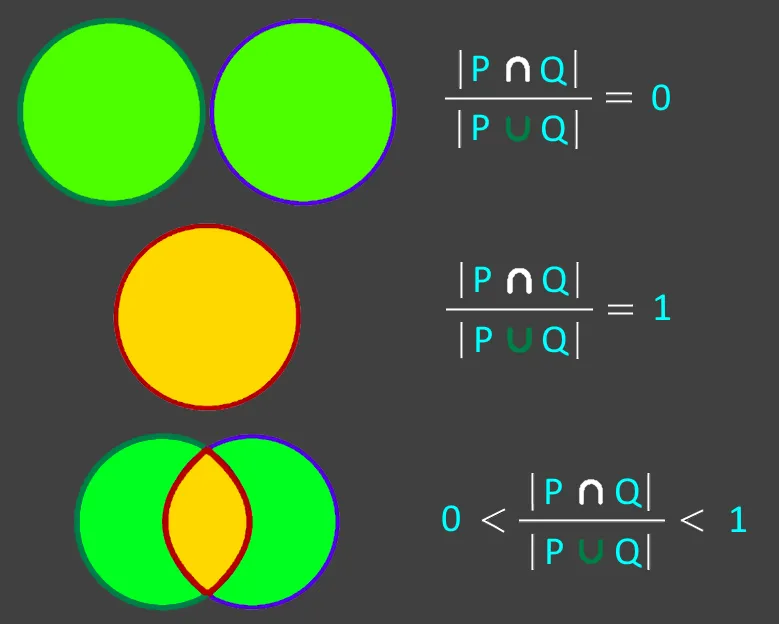

In [32]:
df_final.head()

,movieId,title,genres,genre_set,content,userId,rating,imdbId,tmdbId,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,1,4.00,114709,862,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,5,4.00,114709,862,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,7,4.50,114709,862,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,15,2.50,114709,862,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,17,4.50,114709,862,2011


In [33]:
df_final['genre_set'][0]

{'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'}

In [34]:
df_final_prueba = pd.DataFrame({
      'genre_set': df_final.groupby('title')['genre_set'].first()
  }).reset_index()
df_final_prueba.head(10)

,title,genre_set
0,'71 (2014),"{War, Action, Thriller, Drama}"
1,'Hellboy': The Seeds of Creation (2004),"{Documentary, Adventure, Fantasy, Action, Comedy}"
2,'Round Midnight (1986),"{Drama, Musical}"
3,'Til There Was You (1997),"{Drama, Romance}"
4,'Tis the Season for Love (2015),{Romance}
5,"'burbs, The (1989)",{Comedy}
6,'night Mother (1986),{Drama}
7,(500) Days of Summer (2009),"{Drama, Romance, Comedy}"
8,*batteries not included (1987),"{Sci-Fi, Fantasy, Comedy, Children}"
9,...All the Marbles (1981),"{Drama, Comedy}"


In [35]:
df_final_prueba[df_final_prueba['title'] == '[REC] (2007)']['genre_set'].tolist()[0]

{'Drama', 'Horror', 'Thriller'}

In [36]:
df_final.to_csv('df_jaccard.csv', index=False)

In [37]:
def similitud_jaccard(test, df_final):
  # global df_final
  df_final_2 = pd.DataFrame({'genre_set': df_final.groupby('title')['genre_set'].first()}).reset_index()
  set1 = df_final_2[df_final_2['title'] == test]['genre_set'].tolist()[0]
  df_final_2[f'union - {test}'] = df_final_2['genre_set'].apply(lambda x: len(set1.union(x)))
  df_final_2[f'interseccion - {test}'] = df_final_2['genre_set'].apply(lambda x: len(set1.intersection(x)))
  df_final_2['similitud_jaccard'] = df_final_2[f'interseccion - {test}'] / df_final_2[f'union - {test}']
  df_final_2 = df_final_2.drop(df_final_2[df_final_2['title'] == test].index)
  return df_final_2.sort_values(by='similitud_jaccard', ascending=False).head(10)

In [38]:
similitud_jaccard('[REC] (2007)', df_final)

,title,genre_set,union - [REC] (2007),interseccion - [REC] (2007),similitud_jaccard
3292,Funny Games (1997),"{Drama, Thriller, Horror}",3,3,1.00
7143,Ringu 0: Bâsudei (2000),"{Drama, Thriller, Horror}",3,3,1.00
7931,Split (2017),"{Drama, Thriller, Horror}",3,3,1.00
48,1408 (2007),"{Drama, Thriller, Horror}",3,3,1.00
5476,Mary Reilly (1996),"{Drama, Thriller, Horror}",3,3,1.00
169,A Quiet Place (2018),"{Drama, Thriller, Horror}",3,3,1.00
2479,Don't Look Now (1973),"{Drama, Thriller, Horror}",3,3,1.00
3504,Godsend (2004),"{Drama, Thriller, Horror}",3,3,1.00
1882,"Collector, The (1965)","{Drama, Thriller, Horror}",3,3,1.00
3267,Frozen (2010),"{Drama, Thriller, Horror}",3,3,1.00


In [39]:
similitud_jaccard('Jumanji (1995)', df_final)

,title,genre_set,union - Jumanji (1995),interseccion - Jumanji (1995),similitud_jaccard
2786,Escape to Witch Mountain (1975),"{Fantasy, Children, Adventure}",3,3,1.00
7093,Return to Oz (1985),"{Fantasy, Children, Adventure}",3,3,1.00
4338,"Indian in the Cupboard, The (1995)","{Fantasy, Children, Adventure}",3,3,1.00
323,Alice in Wonderland (1933),"{Fantasy, Children, Adventure}",3,3,1.00
3676,Gulliver's Travels (1996),"{Fantasy, Children, Adventure}",3,3,1.00
322,Alice Through the Looking Glass (2016),"{Fantasy, Children, Adventure}",3,3,1.00
6049,"NeverEnding Story II: The Next Chapter, The (1...","{Fantasy, Children, Adventure}",3,3,1.00
7529,Seventh Son (2014),"{Fantasy, Children, Adventure}",3,3,1.00
6545,Percy Jackson: Sea of Monsters (2013),"{Fantasy, Children, Adventure}",3,3,1.00
3791,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"{Fantasy, Children, Adventure}",3,3,1.00


In [40]:
similitud_jaccard('Toy Story (1995)', df_final)

,title,genre_set,union - Toy Story (1995),interseccion - Toy Story (1995),similitud_jaccard
2721,"Emperor's New Groove, The (2000)","{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
552,Antz (1998),"{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
638,Asterix and the Vikings (Astérix et les Viking...,"{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
7650,Shrek the Third (2007),"{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
245,"Adventures of Rocky and Bullwinkle, The (2000)","{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
5770,"Monsters, Inc. (2001)","{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
9472,"Wild, The (2006)","{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
8277,"Tale of Despereaux, The (2008)","{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
8960,Turbo (2013),"{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00
5724,Moana (2016),"{Adventure, Comedy, Fantasy, Animation, Children}",5,5,1.00


In [41]:
similitud_jaccard("'Hellboy': The Seeds of Creation (2004)", df_final)

,title,genre_set,union - 'Hellboy': The Seeds of Creation (2004),interseccion - 'Hellboy': The Seeds of Creation (2004),similitud_jaccard
2623,Dungeons & Dragons (2000),"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
3327,"Gamers, The: Dorkness Rising (2008)","{Fantasy, Action, Comedy, Adventure}",5,4,0.80
6639,Pirates of the Caribbean: The Curse of the Bla...,"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
1060,Big Trouble in Little China (1986),"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
9659,Your Highness (2011),"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
6635,Pirates of the Caribbean: At World's End (2007),"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
4905,Last Action Hero (1993),"{Fantasy, Action, Comedy, Adventure}",5,4,0.80
3143,"Forbidden Kingdom, The (2008)","{Fantasy, Action, Comedy, Adventure}",5,4,0.80
8337,Teenage Mutant Ninja Turtles III (1993),"{Adventure, Comedy, Fantasy, Action, Children}",6,4,0.67
3724,Hancock (2008),"{Adventure, Fantasy, Action, Crime, Comedy}",6,4,0.67


### ** CON WIDGET **

In [42]:
import ipywidgets as widgets
from IPython.display import display, HTML
import requests

# Supongamos que ya tienes un DataFrame con las películas
df = df_final.groupby('title')['title'].first()

# Crear un widget desplegable
dropdown = widgets.Dropdown(
    options=df.tolist(),
    description='Película:',
    disabled=False,
)

# Crear un widget de salida para mostrar la tabla y las descripciones
recomendaciones_output = widgets.Output()
overview_output = widgets.Output()
poster_output = widgets.Output()

# Función que muestra la selección
def on_select(change):
    seleccion = change['new']

    df_title_tmdbId = df_final.groupby('title')['tmdbId'].first().reset_index()
    api_key = '53881244403c42cb58048b62e1d8fa71'
    tmdb_id = df_title_tmdbId[df_title_tmdbId['title'] == f"{seleccion}"]['tmdbId'].tolist()[0]
    url = f'https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}'

    response = requests.get(url)

    if response.status_code == 200:
        movie_data = response.json()
        # print(movie_data['overview'])
    else:
        print("Error en la solicitud:", response.status_code)

    # Limpiar la salida anterior
    with recomendaciones_output:

        recomendaciones_output.clear_output()  # Limpiar la salida anterior
        overview_output.clear_output()  # Limpiar la salida anterior
        poster_output.clear_output()  # Limpiar la salida anterior
        if seleccion: # Verificar si hay una selección válida

          # Mostrar el poster
          with poster_output:
            poster_output.clear_output()
            print('**********'*5)
            print(f'\nPELÍCULA SELECCIONADA:   {seleccion}\n')
            print('**********'*5)
            poster_url = 'https://image.tmdb.org/t/p/w500' + movie_data['poster_path']
            display(HTML(f'<img src="{poster_url}" width="200" />'))  # Mostrar el poster

          # Mostrar el overview
          with overview_output:
            overview_output.clear_output()
            # print(f'Has seleccionado: --- {seleccion} ---')
            print('************'*8)
            print('Descripción: ')
            display(movie_data['overview'])
            print('************'*8)
            print('Año de realización: ' + movie_data['release_date'])
            print('********'*5)
            print('Duración: ' + str(movie_data['runtime']) + ' min')
            print('********'*5)
            # print('\n')

          # Mostrar la tabla de recomendaciones (si existe)
          with recomendaciones_output:
            recomendaciones =  similitud_jaccard(seleccion, df_final)# recomendaciones con jaccard
            print('\nPELÍCULAS SUGERIDAS: \n')
            display(recomendaciones[1:])  # Mostrar las recomendaciones como tabla
        else:
            print('No hay selección')

# Conectar el widget a la función
dropdown.observe(on_select, names='value')

# Mostrar el widget
display(dropdown, poster_output, overview_output, recomendaciones_output)

Dropdown(description='Película:', options=("'71 (2014)", "'Hellboy': The Seeds of Creation (2004)", "'Round Mi…

Output()

Output()

Output()

### 3.2.2 SIMILITUD DE COSENO

In [43]:
df_final.head()

,movieId,title,genres,genre_set,content,userId,rating,imdbId,tmdbId,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,1,4.00,114709,862,2000
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,5,4.00,114709,862,1996
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,7,4.50,114709,862,2005
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,15,2.50,114709,862,2017
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"{Adventure, Comedy, Fantasy, Animation, Children}",Adventure Animation Children Comedy Fantasy,17,4.50,114709,862,2011


In [44]:
pd.DataFrame({
    'movieId': df_final.groupby('title')['movieId'].first(),
    'genres': df_final.groupby('title')['genres'].first(),
    'tmdbId': df_final.groupby('title')['tmdbId'].first(),
    'content': df_final.groupby('title')['content'].first()
}).reset_index().head(10)

,title,movieId,genres,tmdbId,content
0,'71 (2014),117867,Action|Drama|Thriller|War,252178,Action Drama Thriller War
1,'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy,72867,Action Adventure Comedy Documentary Fantasy
2,'Round Midnight (1986),26564,Drama|Musical,14670,Drama Musical
3,'Til There Was You (1997),779,Drama|Romance,32872,Drama Romance
4,'Tis the Season for Love (2015),149380,Romance,362886,Romance
5,"'burbs, The (1989)",2072,Comedy,11974,Comedy
6,'night Mother (1986),3112,Drama,34760,Drama
7,(500) Days of Summer (2009),69757,Comedy|Drama|Romance,19913,Comedy Drama Romance
8,*batteries not included (1987),8169,Children|Comedy|Fantasy|Sci-Fi,11548,Children Comedy Fantasy Sci-Fi
9,...All the Marbles (1981),5706,Comedy|Drama,30709,Comedy Drama


In [45]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

## Creando un dataframe con todas las películas
df_vectorizer = pd.DataFrame({
    'movieId': df_final.groupby('title')['movieId'].first(),
    'genres': df_final.groupby('title')['genres'].first(),
    'tmdbId': df_final.groupby('title')['tmdbId'].first(),
    'content': df_final.groupby('title')['content'].first()
}).reset_index()

## Creando la matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_vectorizer['content'])

## Calculando la similitud de coseno
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [46]:
cosine_sim

array([[1.        , 0.17077385, 0.11590148, ..., 0.48749924, 0.        ,
        0.        ],
       [0.17077385, 1.        , 0.        , ..., 0.20848204, 0.09995292,
        0.11320842],
       [0.11590148, 0.        , 1.        , ..., 0.        , 0.        ,
        0.84399725],
       ...,
       [0.48749924, 0.20848204, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.09995292, 0.        , ..., 0.        , 1.        ,
        0.14678591],
       [0.        , 0.11320842, 0.84399725, ..., 0.        , 0.14678591,
        1.        ]])

In [47]:
# Guarda el arreglo en un archivo .npy
np.save('cosine_sim_matrix.npy', cosine_sim)

# Carga el arreglo desde el archivo .npy
# cosine_sim_loaded = np.load('cosine_sim_matrix.npy')

Formato .pkl (Pickle):

* Ventajas: Ideal para guardar estructuras de datos complejas como diccionarios o listas de arrays. También es eficiente en términos de espacio y velocidad.
* Uso:


In [48]:
import pickle
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)  # Guardar

# with open('cosine_sim.pkl', 'rb') as f:
#     loaded_sim = pickle.load(f)  # Cargar

In [49]:
print(cosine_sim[2])
print(len(cosine_sim[2]))

[0.11590148 0.         1.         ... 0.         0.         0.84399725]
9712


In [50]:
df_vectorizer.head(5)

,title,movieId,genres,tmdbId,content
0,'71 (2014),117867,Action|Drama|Thriller|War,252178,Action Drama Thriller War
1,'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy,72867,Action Adventure Comedy Documentary Fantasy
2,'Round Midnight (1986),26564,Drama|Musical,14670,Drama Musical
3,'Til There Was You (1997),779,Drama|Romance,32872,Drama Romance
4,'Tis the Season for Love (2015),149380,Romance,362886,Romance


In [51]:
df_vectorizer[df_vectorizer['title'] == "'Hellboy': The Seeds of Creation (2004)"]['movieId'].tolist()[0] ##Indice del titulo seleccionado

97757

In [52]:
df_vectorizer[df_vectorizer['title'] == "Toy Story (1995)"].index[0]

8864

In [53]:
df_vectorizer.shape

(9712, 5)

In [54]:
df_vectorizer.groupby('title')['title'].first().shape

(9712,)

In [55]:
sim_scores = list(enumerate(cosine_sim[8865]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:11]
sim_scores_id = [i[0] for i in sim_scores]
sim_scores_id

[552, 638, 2721, 5724, 5770, 7650, 8277, 8483, 8864, 8865]

In [56]:
df_vectorizer.iloc[sim_scores_id]

,title,movieId,genres,tmdbId,content
552,Antz (1998),2294,Adventure|Animation|Children|Comedy|Fantasy,8916,Adventure Animation Children Comedy Fantasy
638,Asterix and the Vikings (Astérix et les Viking...,91355,Adventure|Animation|Children|Comedy|Fantasy,9642,Adventure Animation Children Comedy Fantasy
2721,"Emperor's New Groove, The (2000)",4016,Adventure|Animation|Children|Comedy|Fantasy,11688,Adventure Animation Children Comedy Fantasy
5724,Moana (2016),166461,Adventure|Animation|Children|Comedy|Fantasy,277834,Adventure Animation Children Comedy Fantasy
5770,"Monsters, Inc. (2001)",4886,Adventure|Animation|Children|Comedy|Fantasy,585,Adventure Animation Children Comedy Fantasy
7650,Shrek the Third (2007),53121,Adventure|Animation|Children|Comedy|Fantasy,810,Adventure Animation Children Comedy Fantasy
8277,"Tale of Despereaux, The (2008)",65577,Adventure|Animation|Children|Comedy|Fantasy,10199,Adventure Animation Children Comedy Fantasy
8483,The Good Dinosaur (2015),136016,Adventure|Animation|Children|Comedy|Fantasy,105864,Adventure Animation Children Comedy Fantasy
8864,Toy Story (1995),1,Adventure|Animation|Children|Comedy|Fantasy,862,Adventure Animation Children Comedy Fantasy
8865,Toy Story 2 (1999),3114,Adventure|Animation|Children|Comedy|Fantasy,863,Adventure Animation Children Comedy Fantasy


In [57]:
df_vectorizer.to_csv('df_coseno.csv', index=False)

In [58]:
def similitud_coseno(test, df_vectorizer):
  index_title = df_vectorizer[df_vectorizer['title'] == test].index[0] ##Index del titulo seleccionado

  ## Consiguiendo las similitudes para el título seleccionado, con respecto al index
  sim_scores = list(enumerate(cosine_sim[index_title]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  sim_scores_id = [i[0] for i in sim_scores]

  ## Armando el de similaridad de coseno
  df_similarity_cosine = df_vectorizer[['movieId', 'title', 'genres']]
  df_similarity_cosine = df_similarity_cosine.iloc[sim_scores_id]
  df_similarity_cosine['similitud_coseno'] = [i[1] for i in sim_scores]
  df_similarity_cosine = df_similarity_cosine.drop(df_similarity_cosine[df_similarity_cosine['title'] == test].index)

  df_similarity_cosine.reset_index(drop=True, inplace=True)

  return df_similarity_cosine.sort_values(by='similitud_coseno', ascending=False)

In [59]:
similitud_coseno('Jumanji (1995)', df_vectorizer)

,movieId,title,genres,similitud_coseno
0,80748,Alice in Wonderland (1933),Adventure|Children|Fantasy,1.00
1,50601,Bridge to Terabithia (2007),Adventure|Children|Fantasy,1.00
2,59501,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure|Children|Fantasy,1.00
3,41566,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure|Children|Fantasy,1.00
4,82169,Chronicles of Narnia: The Voyage of the Dawn T...,Adventure|Children|Fantasy,1.00
5,2043,Darby O'Gill and the Little People (1959),Adventure|Children|Fantasy,1.00
6,1009,Escape to Witch Mountain (1975),Adventure|Children|Fantasy,1.00
7,56171,"Golden Compass, The (2007)",Adventure|Children|Fantasy,1.00
8,173873,Gulliver's Travels (1996),Adventure|Children|Fantasy,1.00
9,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,1.00


In [60]:
similitud_coseno('Toy Story (1995)', df_vectorizer)

,movieId,title,genres,similitud_coseno
0,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1.00
1,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy,1.00
2,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,1.00
3,166461,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy,1.00
4,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,1.00
5,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,1.00
6,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,1.00
7,136016,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy,1.00
8,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,1.00


In [61]:
similitud_coseno("'Hellboy': The Seeds of Creation (2004)", df_vectorizer)

,movieId,title,genres,similitud_coseno
0,3740,Big Trouble in Little China (1986),Action|Adventure|Comedy|Fantasy,0.81
1,3997,Dungeons & Dragons (2000),Action|Adventure|Comedy|Fantasy,0.81
2,59103,"Forbidden Kingdom, The (2008)",Action|Adventure|Comedy|Fantasy,0.81
3,65588,"Gamers, The: Dorkness Rising (2008)",Action|Adventure|Comedy|Fantasy,0.81
4,485,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy,0.81
5,53125,Pirates of the Caribbean: At World's End (2007),Action|Adventure|Comedy|Fantasy,0.81
6,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,0.81
7,87529,Your Highness (2011),Action|Adventure|Comedy|Fantasy,0.81
8,32314,Incident at Loch Ness (2004),Adventure|Comedy|Documentary,0.78
9,102590,Darkon (2006),Documentary|Fantasy,0.77


** **CON WIDGETS** **

In [62]:
import ipywidgets as widgets
from IPython.display import display, HTML
import requests

# Supongamos que ya tienes un DataFrame con las películas
# df = df_final.groupby('title')['title'].first()
df = df_final.groupby('title')['title'].first()

# Crear un widget desplegable
dropdown = widgets.Dropdown(
    options=df.tolist(),
    description='Película:',
    disabled=False,
)

# Crear un widget de salida para mostrar la tabla y las descripciones
recomendaciones_output = widgets.Output()
overview_output = widgets.Output()
poster_output = widgets.Output()

# Función que muestra la selección
def on_select(change):
    seleccion = change['new']

    df_title_tmdbId = df_final.groupby('title')['tmdbId'].first().reset_index()
    api_key = '53881244403c42cb58048b62e1d8fa71'
    tmdb_id = df_title_tmdbId[df_title_tmdbId['title'] == f"{seleccion}"]['tmdbId'].tolist()[0]
    url = f'https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={api_key}'

    response = requests.get(url)

    if response.status_code == 200:
        movie_data = response.json()
        # print(movie_data['overview'])
    else:
        print("Error en la solicitud:", response.status_code)

    # Limpiar la salida anterior
    with recomendaciones_output:

        recomendaciones_output.clear_output()  # Limpiar la salida anterior
        overview_output.clear_output()  # Limpiar la salida anterior
        poster_output.clear_output()  # Limpiar la salida anterior
        if seleccion: # Verificar si hay una selección válida

          # Mostrar el poster
          with poster_output:
            poster_output.clear_output()
            print('**********'*5)
            print(f'\nPELÍCULA SELECCIONADA:   {seleccion}\n')
            print('**********'*5)
            poster_url = 'https://image.tmdb.org/t/p/w500' + movie_data['poster_path']
            display(HTML(f'<img src="{poster_url}" width="200" />'))  # Mostrar el poster

          # Mostrar el overview
          with overview_output:
            overview_output.clear_output()
            # print(f'Has seleccionado: --- {seleccion} ---')
            print('************'*8)
            print('Descripción: ')
            display(movie_data['overview'])
            print('************'*8)
            print('Año de realización: ' + movie_data['release_date'])
            print('********'*5)
            print('Duración: ' + str(movie_data['runtime']) + ' min')
            print('********'*5)
            # print('\n')

          # Mostrar la tabla de recomendaciones (si existe)
          with recomendaciones_output:
            recomendaciones =  similitud_coseno(seleccion, df_vectorizer)# recomendaciones con coseno
            print('\nPELÍCULAS SUGERIDAS: \n')
            display(recomendaciones)  # Mostrar las recomendaciones como tabla
        else:
            print('No hay selección')

# Conectar el widget a la función
dropdown.observe(on_select, names='value')

# Mostrar el widget
display(dropdown, poster_output, overview_output, recomendaciones_output)

Dropdown(description='Película:', options=("'71 (2014)", "'Hellboy': The Seeds of Creation (2004)", "'Round Mi…

Output()

Output()

Output()

## 3.3 RECOMENDACIÓN COLLABORATIVE FILTERING

In [63]:
def agregar_usuario_y_normalizar(ratings_matrix, usuario_nuevo):
    # Convertir el diccionario del usuario nuevo a un DataFrame
    usuario_nuevo_df = pd.DataFrame(usuario).T

    # Alinear las columnas con la matriz de ratings original
    usuario_nuevo_df = usuario_nuevo_df.reindex(columns=ratings_matrix.columns).fillna(0)

    # Calcular la media de ratings
    avg_ratings = usuario_nuevo_df.mean(axis=1).values

    # Normalizar la matriz de ratings
    ratings_usuario_nuevo = usuario_nuevo_df.sub(avg_ratings[0])

    #ratings_matrix_normalized = pd.concat([ratings_matrix_normalized, ratings_usuario_nuevo], ignore_index=True)

    return ratings_usuario_nuevo

In [64]:
def recomendacion_knn(idx, ratings_matrix_normalized, knn_model, n_recommendations=10):
  if type(idx) is not int:
    ratings_usuario_nuevo = agregar_usuario_y_normalizar(ratings_matrix_normalized, idx)
    distances, indices = knn_model.kneighbors(ratings_usuario_nuevo.values.reshape(1,-1), n_neighbors=n_recommendations + 1)
    peliculas_vistas = usuario.index.tolist()

  else:
    distances, indices = knn_model.kneighbors(ratings_matrix_normalized.loc[idx].values.reshape(1,-1), n_neighbors=n_recommendations + 1)
    peliculas_vistas = ratings_matrix.columns[ratings_matrix.loc[idx].values != 0].tolist()

  distances = distances.flatten()[1:]
  indices = indices.flatten()[1:]
  similar_users = ratings_matrix_normalized.iloc[indices]
  mean_ratings = similar_users.T.dot(distances) / np.sum(distances)
  mean_ratings_df = pd.DataFrame(mean_ratings, index=ratings_matrix_normalized.columns, columns=['mean_rating'])
  # Eliminamos las películas que el usuario ya haya visto
  mean_ratings_df = mean_ratings.drop(peliculas_vistas, axis=0)
  mean_ratings_df = mean_ratings_df.dropna()
  return mean_ratings_df

In [65]:
ratings_matrix = df_final.pivot(index='userId', columns='movieId', values='rating').fillna(0)
avg_ratings = ratings_matrix.mean(axis=1)
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0)

In [66]:
ratings_matrix.to_csv('ratings_matrix.csv', index=False)


In [67]:
ratings_matrix_normalized.to_csv('ratings_matrix_normalized.csv', index=False)


In [68]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [69]:
user_number = 15

recomendaciones = recomendacion_knn(user_number, ratings_matrix_normalized, knn_model)
df_filtro_col = recomendaciones.sort_values(ascending=False).reset_index().head(10)


df_filtrado = df_final[df_final['movieId'].isin(df_filtro_col['movieId'])][['movieId','title','tmdbId']].drop_duplicates()

In [70]:
df_filtro_col

,movieId,0
0,7153,3.62
1,593,3.27
2,1291,3.11
3,44191,2.96
4,48516,2.95
5,4011,2.80
6,33794,2.69
7,110,2.64
8,68157,2.51
9,6539,2.40


In [71]:
df_filtrado

,movieId,title,tmdbId
3387,110,Braveheart (1995),197
16228,593,"Silence of the Lambs, The (1991)",274
29322,1291,Indiana Jones and the Last Crusade (1989),89
59213,4011,Snatch (2000),107
71343,6539,Pirates of the Caribbean: The Curse of the Bla...,22
73847,7153,"Lord of the Rings: The Return of the King, The...",122
80002,33794,Batman Begins (2005),272
81872,44191,V for Vendetta (2006),752
83495,48516,"Departed, The (2006)",1422
89024,68157,Inglourious Basterds (2009),16869


In [72]:
#comprobamos que se eliminaron las peliculas ya vistas
peliculas_vistas = ratings_matrix.columns[ratings_matrix.loc[15].values != 0].tolist()
df_filtrado['movieId'].isin(peliculas_vistas)

,movieId
3387,False
16228,False
29322,False
59213,False
71343,False
73847,False
80002,False
81872,False
83495,False
89024,False


## Usuario nuevo

In [73]:
usuario = pd.Series({2:1, 356:4, 58559:5})
n_recommendations = 5

In [74]:
recomendaciones2 = recomendacion_knn(usuario, ratings_matrix_normalized, knn_model)
df_filtro_col2 = recomendaciones2.sort_values(ascending=False).reset_index().head(10)


df_filtrado2 = df_final[df_final['movieId'].isin(df_filtro_col2['movieId'])][['movieId','title','tmdbId']].drop_duplicates()

In [75]:
df_filtro_col2

,movieId,0
0,2571,3.85
1,79132,2.89
2,318,2.73
3,260,2.23
4,50,2.16
5,858,1.93
6,296,1.83
7,109487,1.81
8,593,1.75
9,1196,1.71


In [76]:
df_filtrado2

,movieId,title,tmdbId
2379,50,"Usual Suspects, The (1995)",629
6853,260,Star Wars: Episode IV - A New Hope (1977),11
7860,296,Pulp Fiction (1994),680
8652,318,"Shawshank Redemption, The (1994)",278
16228,593,"Silence of the Lambs, The (1991)",274
19830,858,"Godfather, The (1972)",238
24640,1196,Star Wars: Episode V - The Empire Strikes Back...,1891
45011,2571,"Matrix, The (1999)",603
91343,79132,Inception (2010),27205
96714,109487,Interstellar (2014),157336


### PRUEBAS

In [77]:
## Importando la librería a utilizar para crear base de datos
from sqlalchemy import create_engine, MetaData, Table, inspect, text
## Creamos un engine con el motor de banco de datos
database = create_engine('sqlite:///:memory:')
database



Engine(sqlite:///:memory:)

In [78]:
## Asignamos los dataframes a la base de datos en forma de tablas
#df_final.to_sql('df_final2',database, index=False)
